In [94]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs, make_circles, make_moons
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

Converged at iteration 6


NameError: name 'X_fit_' is not defined

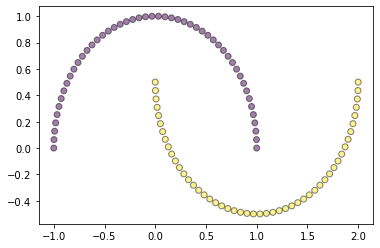

In [150]:
"""Kernel K-means"""

import numpy as np

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state


class KernelKMeans(BaseEstimator, ClusterMixin):

    def __init__(self, n_clusters=3, max_iter=50, tol=1e-3, random_state=None,
                 kernel="polynomial", gamma=None, degree=3, coef0=1,
                 kernel_params=None, verbose=0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.kernel_params = kernel_params
        self.verbose = verbose
        
    @property
    def _pairwise(self):
        return self.kernel == "precomputed"

    def _get_kernel(self, X, Y=None):
        if callable(self.kernel):
            params = self.kernel_params or {}
        else:
            params = {"gamma": self.gamma,
                      "degree": self.degree,
                      "coef0": self.coef0}
        return pairwise_kernels(X, Y, metric=self.kernel,
                                filter_params=True, **params)

    def fit(self, X, y=None, sample_weight=None):
        n_samples = X.shape[0]

        K = self._get_kernel(X)

        sw = sample_weight if sample_weight else np.ones(n_samples)
        self.sample_weight_ = sw

        rs = check_random_state(self.random_state)
        self.labels_ = rs.randint(self.n_clusters, size=n_samples)

        dist = np.zeros((n_samples, self.n_clusters))
        self.within_distances_ = np.zeros(self.n_clusters)

        for it in range(self.max_iter):
            dist.fill(0)
            self._compute_dist(K, dist, self.within_distances_,
                               update_within=True)
            labels_old = self.labels_
            self.labels_ = dist.argmin(axis=1)
            
            n_same = np.sum((self.labels_ - labels_old) == 0)
            if 1 - float(n_same) / n_samples < self.tol:
                if self.verbose:
                    print ("Converged at iteration", it + 1)
                break

        self.X_fit_ = X

        return self

    def _compute_dist(self, K, dist, within_distances, update_within):

        sw = self.sample_weight_

        for j in range(self.n_clusters):
            mask = self.labels_ == j

            if np.sum(mask) == 0:
                raise ValueError("Empty cluster found, try smaller n_cluster.")

            denom = sw[mask].sum()
            denomsq = denom * denom

            if update_within:
                KK = K[mask][:, mask]  # K[mask, mask] does not work.
                dist_j = np.sum(np.outer(sw[mask], sw[mask]) * KK / denomsq)
                within_distances[j] = dist_j
                dist[:, j] += dist_j
            else:
                dist[:, j] += within_distances[j]

            dist[:, j] -= 2 * np.sum(sw[mask] * K[:, mask], axis=1) / denom

    def predict(self, X):
        K = self._get_kernel(X ,X_fit_)
        n_samples = X.shape[0]
        dist = np.zeros((n_samples, self.n_clusters))
        self._compute_dist(K, dist, self.within_distances_,
                           update_within=False)
        return dist.argmin(axis=1) ,k

if __name__ == '__main__':
    from sklearn.datasets import make_moons
    X, y = make_moons(n_samples=100)
    
    plt.scatter(X[:, 0], X[: ,1],c=y, edgecolor='k', alpha=0.5)

    km = KernelKMeans(n_clusters=2, max_iter=100, random_state=0, verbose=1)
    #km.fit_predict(X)
    km.fit(X)
    temp ,k = km.predict(X)

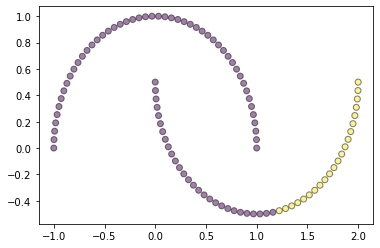

In [146]:
plt.scatter(X[:, 0], X[: ,1],c=temp, edgecolor='k', alpha=0.5)

In [128]:
from scipy.sparse import issparse
import numpy as np
from sklearn.datasets import make_moons
from sklearn.utils import check_array

x ,y = make_moons(n_samples=10)

In [120]:
x.shape

(10, 2)

In [52]:
def _return_float_dtype(X, Y):
    """
    1. If dtype of X and Y is float32, then dtype float32 is returned.
    2. Else dtype float is returned.
    """
    if not issparse(X) and not isinstance(X, np.ndarray):
        print("A")
        X = np.asarray(X)

    if Y is None:
        print("B")
        Y_dtype = X.dtype
    elif not issparse(Y) and not isinstance(Y, np.ndarray):
        print("C")
        Y = np.asarray(Y)
        Y_dtype = Y.dtype
    else:
        print("D")
        Y_dtype = Y.dtype

    if X.dtype == Y_dtype == np.float32:
        print("F")
        dtype = np.float32
    else:
        print("E")
        dtype = float

    return X, Y, dtype

In [101]:
def check_pairwise_arrays(
    X,
    Y,
    *,
    precomputed=False,
    dtype=None,
    accept_sparse="csr",
    force_all_finite=True,
    copy=False,
):
   
    X, Y, dtype_float = _return_float_dtype(X, Y)

    estimator = "check_pairwise_arrays"
    if dtype is None:
        dtype = dtype_float

    if Y is X or Y is None:
        X = Y = check_array(
            X,
            accept_sparse=accept_sparse,
            dtype=dtype,
            copy=copy,
            force_all_finite=force_all_finite,
            estimator=estimator,
        )
    else:
        X = check_array(
            X,
            accept_sparse=accept_sparse,
            dtype=dtype,
            copy=copy,
            force_all_finite=force_all_finite,
            estimator=estimator,
        )
        Y = check_array(
            Y,
            accept_sparse=accept_sparse,
            dtype=dtype,
            copy=copy,
            force_all_finite=force_all_finite,
            estimator=estimator,
        )

    if precomputed:
        if X.shape[1] != Y.shape[0]:
            raise ValueError(
                "Precomputed metric requires shape "
                "(n_queries, n_indexed). Got (%d, %d) "
                "for %d indexed." % (X.shape[0], X.shape[1], Y.shape[0])
            )
    elif X.shape[1] != Y.shape[1]:
        raise ValueError(
            "Incompatible dimension for X and Y matrices: "
            "X.shape[1] == %d while Y.shape[1] == %d" % (X.shape[1], Y.shape[1])
        )

    return X, Y



In [102]:
X , Y ,d = _return_float_dtype(x ,y)

D
E


In [103]:
x.shape

(10, 2)

In [104]:
from sklearn.metrics import pairwise

In [111]:
X = pairwise.polynomial_kernel(x)

In [112]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs, make_circles, make_moons
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

In [113]:
X.shape

(10, 10)

In [114]:
X

array([[3.37500000e+00, 1.50682044e+00, 1.00000000e+00, 1.25000000e-01,
        2.70145654e-01, 2.47985435e+00, 8.00000000e+00, 6.36817956e+00,
        1.00000000e+00, 3.37500000e+00],
       [1.50682044e+00, 1.20570467e+00, 8.52573588e-01, 6.21859217e-01,
        5.57895642e-01, 1.09377790e+00, 1.91177894e+00, 2.05539069e+00,
        7.20399308e-01, 1.72033603e+00],
       [1.00000000e+00, 8.52573588e-01, 1.42382812e+00, 1.00000000e+00,
        1.62960436e+00, 1.62960436e+00, 1.42382812e+00, 8.52573588e-01,
        1.95312500e+00, 6.69921875e-01],
       [1.25000000e-01, 6.21859217e-01, 1.00000000e+00, 3.37500000e+00,
        2.47985435e+00, 2.70145654e-01, 0.00000000e+00, 3.14078323e-03,
        1.00000000e+00, 1.25000000e-01],
       [2.70145654e-01, 5.57895642e-01, 1.62960436e+00, 2.47985435e+00,
        3.37500000e+00, 1.00000000e+00, 1.03604406e-01, 3.37682068e-02,
        2.47985435e+00, 1.03604406e-01],
       [2.47985435e+00, 1.09377790e+00, 1.62960436e+00, 2.70145654e-01,
   

In [115]:
y

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0])

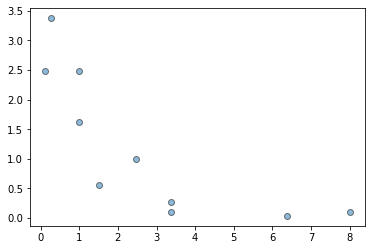

In [118]:
plt.scatter(X[:,0],X[:,4],
            edgecolor='k', alpha=0.5)

In [151]:
from sklearn.utils.extmath import safe_sparse_dot

In [155]:
def polynomial_kernel(X, Y=None, degree=3, gamma=None, coef0=1):
    
    X, Y = check_pairwise_arrays(X, Y)
    if gamma is None:
        gamma = 1.0 / X.shape[1]

    K = safe_sparse_dot(X, Y.T, dense_output=True)
    K *= gamma
    K += coef0
    K **= degree
    return K


In [178]:
X, y = make_moons(n_samples=10)
tempData = X

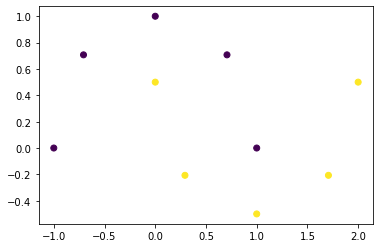

In [179]:
plt.scatter(X[:,0] ,X[:,1] ,c = y)

In [180]:
X = polynomial_kernel(X)

B
E


In [181]:
X.shape

(10, 10)

In [182]:
k_means = KMeans(n_clusters=2, random_state=0).fit(X)
temp = k_means.predict(X)
temp

array([1, 0, 1, 1, 0, 0, 1, 0, 0, 1], dtype=int32)

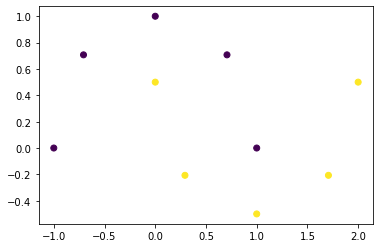

In [185]:
plt.scatter(tempData[:,0] ,tempData[:,1] ,c = y)

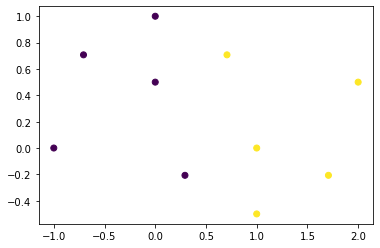

In [184]:
plt.scatter(tempData[:,0] ,tempData[:,1] ,c = temp)

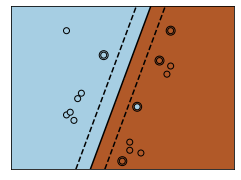

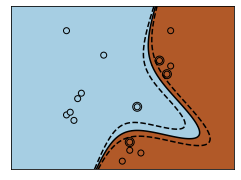

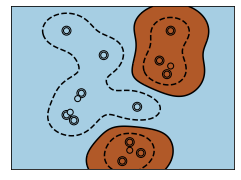

In [186]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm


# Our dataset and targets
X = np.c_[
    (0.4, -0.7),
    (-1.5, -1),
    (-1.4, -0.9),
    (-1.3, -1.2),
    (-1.1, -0.2),
    (-1.2, -0.4),
    (-0.5, 1.2),
    (-1.5, 2.1),
    (1, 1),
    # --
    (1.3, 0.8),
    (1.2, 0.5),
    (0.2, -2),
    (0.5, -2.4),
    (0.2, -2.3),
    (0, -2.7),
    (1.3, 2.1),
].T
Y = [0] * 8 + [1] * 8

# figure number
fignum = 1

# fit the model
for kernel in ("linear", "poly", "rbf"):
    clf = svm.SVC(kernel=kernel, gamma=2)
    clf.fit(X, Y)

    # plot the line, the points, and the nearest vectors to the plane
    plt.figure(fignum, figsize=(4, 3))
    plt.clf()

    plt.scatter(
        clf.support_vectors_[:, 0],
        clf.support_vectors_[:, 1],
        s=80,
        facecolors="none",
        zorder=10,
        edgecolors="k",
    )
    plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired, edgecolors="k")

    plt.axis("tight")
    x_min = -3
    x_max = 3
    y_min = -3
    y_max = 3

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(fignum, figsize=(4, 3))
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(
        XX,
        YY,
        Z,
        colors=["k", "k", "k"],
        linestyles=["--", "-", "--"],
        levels=[-0.5, 0, 0.5],
    )

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())
    fignum = fignum + 1
plt.show()